## Stochastic gradient descent

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

mnist_train = pd.read_csv("mnist_train.csv", header=None)
mnist_test = pd.read_csv("mnist_test.csv", header = None)
n,d = mnist_train.shape
ntest, dtest = mnist_test.shape


y_train = mnist_train.iloc[:,0]
X_train = mnist_train.iloc[:,1:]
X_train /= 255
X_train = np.array(X_train)

y_test = mnist_test.iloc[:,0]
X_test = mnist_test.iloc[:,1:]
X_test /= 255
X_test = np.array(X_test)


y_train = 2*np.array(y_train == 0)-1 # binary classification
y_test = 2*np.array(y_test == 0)-1 

### Functions for SGD

In [2]:
def hinge_reg_sgd(x, a, b, lamb):
    threshold = b*np.dot(a,x)[0]
    cost = np.maximum(1 - threshold,0)
    return cost + lamb*np.dot(x.T,x)/2

In [3]:
def grad_reg_sgd(x, a, b, lamb, d):
    threshold = b*np.dot(a,x)[0]

    if (threshold >= 1):
        grad = np.zeros(d)
    else:
        grad = -b*a

    return grad.reshape(d,) + lamb*x

In [4]:
def hingereg(x, a, b, lamb):
    threshold = np.multiply(np.dot(a,x), b) 
    cost = np.maximum(1 - threshold,0)
    return cost.mean() + lamb*np.dot(x.T,x)/2

In [5]:
def gradreg(x, a, b, lamb):
    n,d = a.shape
    threshold = np.multiply(np.dot(a,x) , b)
    grad = -np.multiply(a, b.reshape(b.shape[0],1))
    idx_zeros = (threshold >= 1)
    grad[idx_zeros,:] = np.zeros(d)
    return grad.sum(axis=0)/n + lamb*x

In [6]:
def SGD(a, b, init, iters, cost,  grad, lamb, X_test = None, y_test = None):

    start_time = time.time()
    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    params = []
    costs = []
    test_scores = []
    params.append(init)
    p_mean = np.zeros(d)
    
    for i in range(1,iters+1):

        eta = lamb/np.sqrt(i+1) 
        x_i = a[indices[i-1],:].reshape(1,d)
        y_i = b[indices[i-1]]
        p = params[-1] - eta * grad(params[-1], x_i, y_i, lamb, d)
        p_mean += p
        params.append(p)
        c = hingereg(p, a, b, lamb)
        costs.append(c)
        test_score = (np.multiply(np.matmul(X_test,p_mean/i), y_test) > 0).mean() 
        test_scores.append(test_score)
    
    
    end_time = time.time()
    print("Time of execution : %s seconds" % (end_time - start_time)) 
    return params, costs, np.array(test_scores)

#### Train for MNIST

In [7]:
x0 = np.zeros(784)
niter = 250
params, costs, test_scores = SGD(X_train, y_train, x0, niter, hinge_reg_sgd, grad_reg_sgd, (1/3), X_test, y_test)

Time of execution : 12.69133734703064 seconds


max test scores : 0.9137
last test scores : 0.9137
Estimated convergence rate : -0.03075270297122766


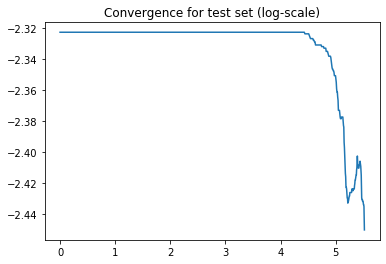

In [8]:
print("max test scores : {}".format(max(test_scores)))
print("last test scores : {}".format(test_scores[-1]))

plt.plot(np.log(range(1, niter+1)), np.log(1-test_scores))
plt.title("Convergence for test set (log-scale)")
lm = LinearRegression()
lm.fit(np.log(range(1, niter+1)).reshape(niter,1), np.log(1-test_scores))
regCoeff = lm.coef_[0]
print("Estimated convergence rate : {}".format(regCoeff))
plt.show()

### Projected SGD

In [9]:
def proj_simplex(x, z=1):

    d = x.shape[0]
    x_sorted = -np.sort(-x) 
    x_cumsum = np.cumsum(x_sorted)
    find = x_sorted - (1/np.arange(1,d+1,1))*(x_cumsum - z)
    d0 = np.argmax(find <= 0) #+ 1
    theta_star = (1/d0)*(x_cumsum[d0-1] - z)

    return np.maximum(x-theta_star,0)


def proj_l1(x, z=1):
    x_abs = np.absolute(x)
    if (np.sum(x_abs) > z):
        p_simplex = proj_simplex(x_abs, z)
        sgn = 2*(x>0)-1
        x = np.multiply(sgn, p_simplex)    
    return x

In [10]:
def proj_SGD(a, b, init, iters, cost,  grad, lamb, X_test = None, y_test = None, z=10):

    start_time = time.time()
    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    params = []
    costs = []
    test_scores = []
    params.append(init)
    p_mean = init
    
    for i in range(1,iters+1):

        eta = lamb/np.sqrt(i+1) 
        x_i = a[indices[i-1],:].reshape(1,d)
        y_i = b[indices[i-1]]
        y = params[-1] - eta * grad(params[-1], x_i, y_i, lamb, d)
        p = proj_l1(y, z)
        p_mean += p
        params.append(p)
        c = hingereg(p, a, b, lamb)
        costs.append(c)
        test_score = (np.multiply(np.matmul(X_test,p_mean/i), y_test) > 0).mean() 
        test_scores.append(test_score)
    
    
    end_time = time.time()
    print("Time of execution : %s seconds" % (end_time - start_time)) 
    return params, costs, np.array(test_scores)

In [11]:
x0 = np.zeros(784)
niter = 250 
z=10
params_proj, costs_proj, test_scores_proj = proj_SGD(X_train, y_train, x0, niter, hinge_reg_sgd, grad_reg_sgd, (1/3), X_test, y_test, z)

Time of execution : 8.049211502075195 seconds


max test scores : 0.9445
last test scores : 0.9445


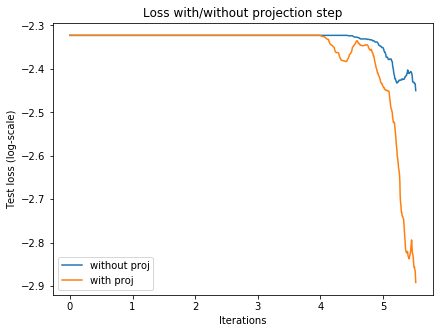

In [12]:
print("max test scores : {}".format(max(test_scores_proj)))
print("last test scores : {}".format(test_scores_proj[-1]))

# Plot convergence rate with/without projection step

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(np.log(range(1, niter+1)), np.log(1-test_scores), label = "without proj")
plt.plot(np.log(range(1, niter+1)), np.log(1-test_scores_proj), label = "with proj")
plt.xlabel("Iterations")
plt.ylabel("Test loss (log-scale)")
plt.title("Loss with/without projection step")
plt.legend()
plt.show()